In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("data/netcdf_and_cao/cao_1_5_std.csv",sep=";")

In [4]:
ds = xr.open_dataset(r"data\netcdf_and_cao\subset_Rolling_daily_standard_anomaly.nc")
ds

<xarray.Dataset> Size: 990MB
Dimensions:       (latitude: 53, longitude: 77, time: 30316)
Coordinates:
  * latitude      (latitude) float32 212B 50.0 49.75 49.5 ... 37.5 37.25 37.0
  * longitude     (longitude) float32 308B -87.0 -86.75 -86.5 ... -68.25 -68.0
  * time          (time) datetime64[ns] 243kB 1940-01-01 ... 2022-12-31
    dayofyear     (time) int64 243kB ...
Data variables:
    daily_t2_min  (time, latitude, longitude) float64 990MB ...

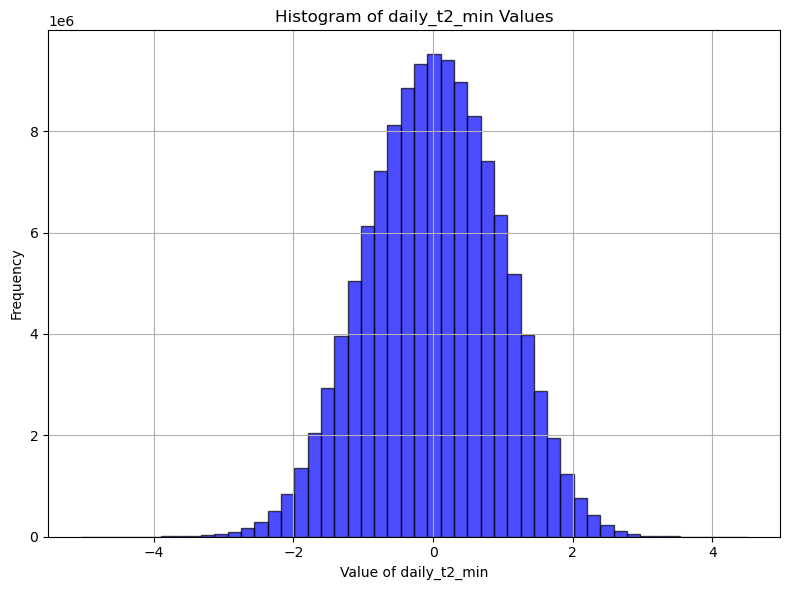

In [5]:
# Select the 'daily_t2_min' variable from the dataset
daily_t2_min_data = ds['daily_t2_min']

# Convert to NumPy array (this loads the data into memory, be mindful if the dataset is large)
# You might want to use .compute() only if the data is too large
data_values = daily_t2_min_data.values

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(data_values.flatten(), bins=50, color='blue', edgecolor='black', alpha=0.7)

# Customize the plot
plt.xlabel('Value of daily_t2_min')
plt.ylabel('Frequency')
plt.title('Histogram of daily_t2_min Values')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [6]:
ds['time'] = pd.to_datetime(ds['time'].values)
ds_filtered = ds.sel(time=df["time"].values)

In [7]:
condition = ds_filtered['daily_t2_min'] <= -1.5
mask = condition.isel(latitude=slice(None), longitude=slice(None)).any(dim=['latitude', 'longitude'])
ds_filtered_condition = ds_filtered.sel(time=mask)

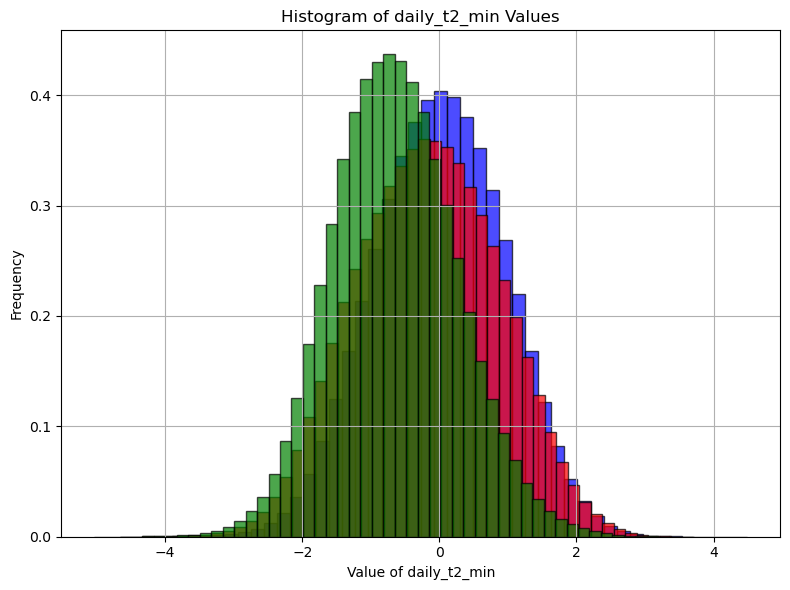

In [8]:
daily_t2_min_data = ds_filtered['daily_t2_min']
data_values_cao = daily_t2_min_data.values

daily_t2_min_data = ds_filtered_condition['daily_t2_min']
data_values_cao_subset = daily_t2_min_data.values

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(data_values.flatten(), bins=50, color='blue', edgecolor='black', alpha=0.7,density=True)
plt.hist(data_values_cao.flatten(), bins=50, color='red', edgecolor='black', alpha=0.7,density=True)
plt.hist(data_values_cao_subset.flatten(), bins=50, color='green', edgecolor='black', alpha=0.7,density=True)

# Customize the plot
plt.xlabel('Value of daily_t2_min')
plt.ylabel('Frequency')
plt.title('Histogram of daily_t2_min Values')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

#### Area with CAO points

In [9]:
# Apply the condition to check where 'daily_t2_min' <= -1.5
condition = ds_filtered['daily_t2_min'] <= -1.5

# Count the number of grid points satisfying the condition for each time step
count_condition = condition.sum(dim=['latitude', 'longitude'])

# Calculate the total number of grid points in the domain (this is fixed for the dataset)
total_grid_points = np.prod(condition.shape[1:])  # product of latitude and longitude dimensions

# Calculate the area coverage: the ratio of grid points satisfying the condition to the total grid points
area_coverage = count_condition / total_grid_points

In [24]:
avg_std =   ds_filtered['daily_t2_min'].mean(dim=['latitude', 'longitude'])#average standard deviation
avg_std = avg_std.values

In [25]:
df_summary=pd.DataFrame()
df_summary["avg_std"] = avg_std
df_summary["area_coverage"] = area_coverage.values
df_summary["time"] = area_coverage["time"].values

#### Area coverage within subset region for all CAO dates

<Axes: >

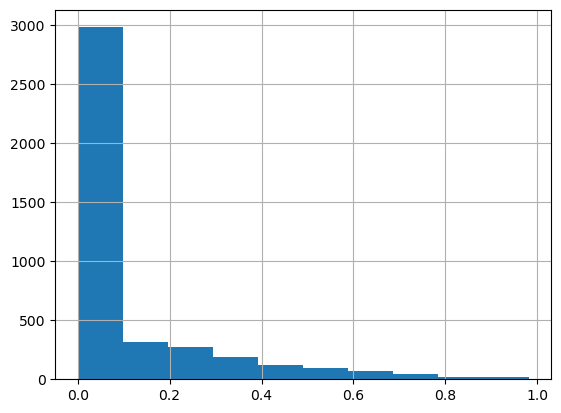

In [26]:
df_summary["area_coverage"].hist()

<Axes: >

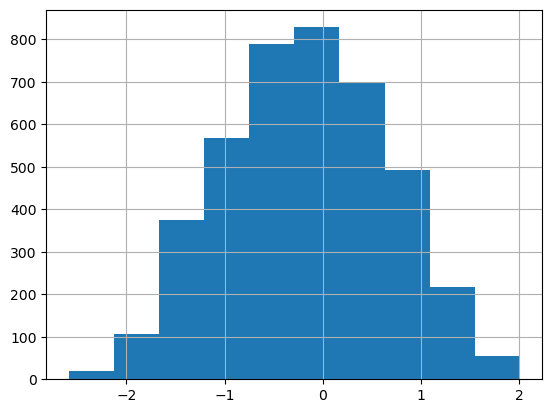

In [27]:
df_summary["avg_std"].hist()

In [28]:
df["time"] = pd.to_datetime(df["time"].values)
df_summary["time"] = pd.to_datetime(df_summary["time"].values)
merged_df = df_summary.merge(df, on='time')

In [29]:
merged_df[merged_df['cao_group']==998]

,avg_std,area_coverage,time,index,region_label,npoints,weigthed_area,center_of_mass_lat,center_of_mass_lon,center_of_mass_lat_v2,...,average_inside_region,median_inside_region,time_diff,distance,group,increments,increments_sum,cao_group,pre_group,new_group
4136,0.433431,0.060524,2022-02-12,7172,39,1041,681.3584,49.25,-90.75,49.00,...,-1.694071,-1.674591,5.0,2609.886420,651,1,1375,998.0,2.0,1.0
4137,-0.637993,0.285469,2022-02-13,7173,51,1881,1250.5400,48.25,-83.25,47.75,...,-1.769744,-1.747219,1.0,481.940732,651,0,1375,998.0,0.0,0.0
4138,-1.158365,0.272727,2022-02-14,7175,28,2049,1281.9185,51.25,-65.00,49.75,...,-1.695527,-1.637989,1.0,959.578879,651,0,1375,998.0,0.0,0.0


In [31]:
merged_df.columns

Index(['avg_std', 'area_coverage', 'time', 'index', 'region_label', 'npoints',
       'weigthed_area', 'center_of_mass_lat', 'center_of_mass_lon',
       'center_of_mass_lat_v2', 'center_of_mass_lon_v2', 'min_lat', 'min_lon',
       'stdev', 'min_inside_region', 'min_overall', 'average_inside_region',
       'median_inside_region', 'time_diff', 'distance', 'group', 'increments',
       'increments_sum', 'cao_group', 'pre_group', 'new_group'],
      dtype='object')

In [ ]:
merged_df["month"] = merged_df["time"].dt.month
merged_df["year"] = merged_df["time"].dt.year
merged_df[merged_df["month"]==12]["year"]

merged_df['season_year'] = merged_df['month'].apply(lambda x: 1 if x == 12 else 0)
merged_df["year"] = merged_df["year"] + merged_df['season_year'] 
merged_df.drop('season_year',axis=1,inplace=True)
merged_df.drop('month',axis=1,inplace=True)

In [46]:
merged_df = merged_df[['time','year','cao_group','avg_std','area_coverage']]

In [47]:
merged_df.to_csv(r"data\ready\CAO_data.csv",sep=";",index=False)

In [ ]:
merged_df['is_cao_day'] = merged_df['area_coverage'].apply(lambda x: 1 if x > 0.25 else 0)

In [61]:
avg_CAO_day_year = merged_df.groupby("year")["is_cao_day"].sum().mean()
print(avg_CAO_day_year)

8.24390243902439


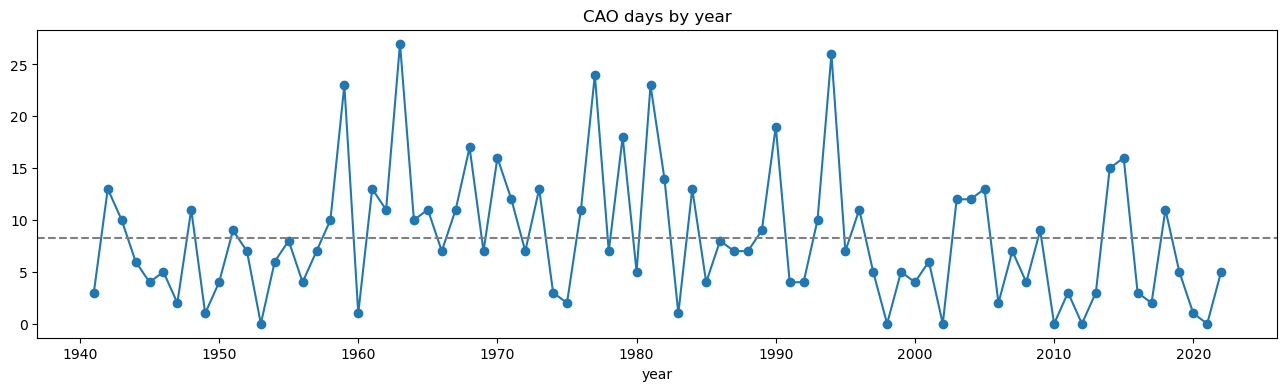

In [81]:
plt.figure(figsize=(16,4))
\
merged_df.groupby("year")["is_cao_day"].sum().plot(style='-o')
plt.title("CAO days by year")
plt.axhline(avg_CAO_day_year,linestyle="--",color="gray")

np.float64(8.24390243902439)

In [17]:
df_cao_on = merged_df[merged_df["area_coverage"]>0.25]
df_cao_on_summary=df_cao_on[["area_coverage",'ASD']].groupby(df_cao_on["cao_group"]).agg({'min','max', 'count'})
#df_cao_on_summary.reset_index().sort_values(by="count")

In [18]:
df_cao_on_summary

area_coverage                       ASD                
                    min       max count       min       max count
cao_group                                                        
0.0            0.263416  0.263416     1 -0.863263 -0.863263     1
2.0            0.274443  0.274443     1 -1.102349 -1.102349     1
6.0            0.381279  0.381279     1 -1.148131 -1.148131     1
7.0            0.290615  0.581230     3 -1.474373 -0.660361     3
8.0            0.250674  0.873315     5 -1.992205 -1.231921     5
...                 ...       ...   ...       ...       ...   ...
981.0          0.367557  0.367557     1 -1.047978 -1.047978     1
991.0          0.425386  0.425386     1 -1.351654 -1.351654     1
992.0          0.405783  0.405783     1 -1.172017 -1.172017     1
994.0          0.333987  0.333987     1 -1.140779 -1.140779     1
998.0          0.272727  0.285469     2 -1.158365 -0.637993     2

[314 rows x 6 columns]

#### Looking into some events

In [19]:
from matplotlib.colors import TwoSlopeNorm
import matplotlib.colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [20]:
datei='1979-02-04'
datef='1979-02-05'

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["purple","darkblue","blue","lightblue","white","lightcoral","red","darkred","pink"])
z = [-3.5,-3.0,-2.5,-2.0,-1.5,-1.0,-.5,0,.1,1.0,2.0,5.0]
norm = TwoSlopeNorm(vmin=np.min(z), vcenter=0, vmax=np.max(z))

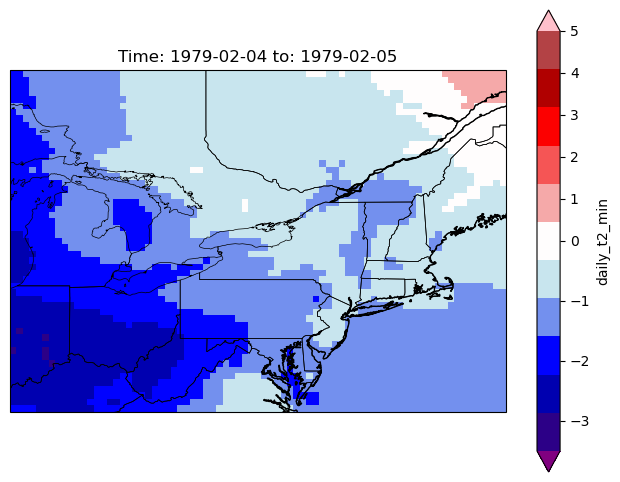

In [21]:
plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
#ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
ds['daily_t2_min'].sel(time=slice(datei,datef)).min("time").plot(cmap=cmap,norm=norm,levels=z,extend="both",transform=ccrs.PlateCarree())
plt.title(f'Time: {str(datei)} to: {datef}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax.coastlines()
ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
plt.show()

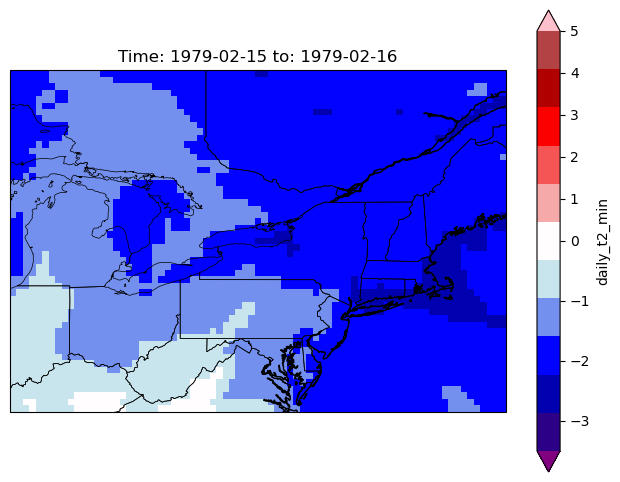

In [22]:
datei='1979-02-15'
datef='1979-02-16'

plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
#ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
ds['daily_t2_min'].sel(time=slice(datei,datef)).min("time").plot(cmap=cmap,norm=norm,levels=z,extend="both",transform=ccrs.PlateCarree())
plt.title(f'Time: {str(datei)} to: {datef}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax.coastlines()
ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
plt.show()

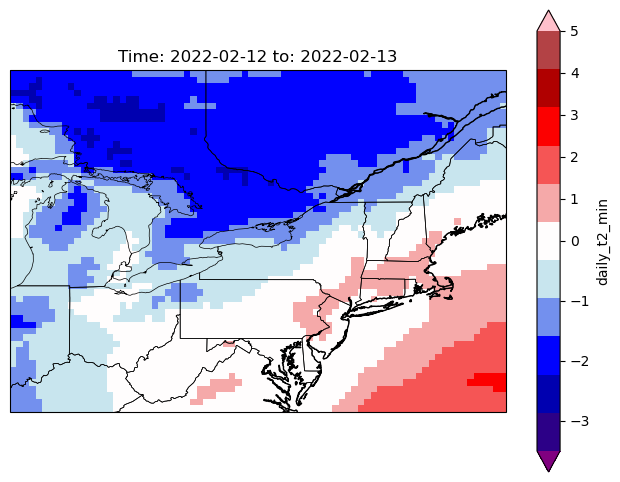

In [23]:
datei='2022-02-12'
datef='2022-02-13'

plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
#ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
ds['daily_t2_min'].sel(time=slice(datei,datef)).min("time").plot(cmap=cmap,norm=norm,levels=z,extend="both",transform=ccrs.PlateCarree())
plt.title(f'Time: {str(datei)} to: {datef}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax.coastlines()
ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
plt.show()